In [158]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd
import osmium
from shapely.geometry import Polygon
import json
import fiona
import os
from shapely.geometry import shape 
import contextily as ctx
from sklearn.preprocessing import OneHotEncoder
from shapely.geometry import Point, Polygon
import folium


for module in [pd, gpd]:
    print(module.__name__, module.__version__)

pandas 1.2.4
geopandas 0.9.0


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#os.mkdir('map_data')

In [4]:
%%bash
wget https://download.bbbike.org/osm/extract/planet_-9.48,38.673_-9.027,38.891.osm.pbf \
    --quiet -O map_data/Porto.osm.pbf

In [5]:
%%bash
wget https://download.bbbike.org/osm/extract/planet_-8.673_41.148_5f89bc30.osm.pbf \
    --quiet -O map_data/Lisbon.osm.pbf

# Loading Data 

## Challenge Data

In [25]:
green_areas = pd.read_csv('https://raw.githubusercontent.com/SowmyaMadala/WDL-Stage4/main/Data/Attracting%20Population/WDL_Green_Areas_Dataset_V1.txt', 
                          sep ="|", 
                          encoding ="latin-1").rename(columns = {'Number of Museums in influence area' : 'no_of_museums',
                                                                 'Number of parking lots in influence area' : 'no_of_parking_lots',
                                                                'Number of tourist attractions in influence area': 'no_of_tourist_attractions', 
                                                                'Green Zones Daily Average Demand':'gz_daily_avg_demand',
                                                                'Daily average of people in influence area': 'daily_avg_people',
                                                                'Number of buildings in influence area' : 'no_of_buildings',
                                                                'Number of families in influence area': 'no_of_families',
                                                                'Number of people resident in influence area' : 'no_of_people_resident'
                                                                })

green_areas.shape, green_areas.dtypes


((128, 14),
 Green_Zone_name               object
 no_of_museums                  int64
 no_of_parking_lots             int64
 no_of_tourist_attractions      int64
 gz_daily_avg_demand          float64
 Resident                       int64
 daily_avg_people             float64
 no_of_buildings                int64
 no_of_families                 int64
 no_of_people_resident          int64
 perc_senior_pop              float64
 perc_pop_until_19_yo         float64
 POINT_X                      float64
 POINT_Y                      float64
 dtype: object)

In [172]:
# preprocessed park polygons
path = "map_data/parks_parishes.geojson"
green_areas_shape = gpd.read_file(path)

## Lisbon

In [6]:
!ogrinfo map_data/Lisbon.osm.pbf

INFO: Open of `map_data/Lisbon.osm.pbf'
      using driver `OSM' successful.
1: points (Point)
2: lines (Line String)
3: multilinestrings (Multi Line String)
4: multipolygons (Multi Polygon)
5: other_relations (Geometry Collection)


In [7]:
%%bash
ogr2ogr -f "GPKG" \
    map_data/lisbon_polygons.gpkg \
    map_data/Lisbon.osm.pbf \
    -nlt POLYGONS \
    -nln polygons

0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: A geometry of type POINT is inserted into layer polygons of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.
Warning 1: A geometry of type LINESTRING is inserted into layer polygons of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.
Warning 1: A geometry of type MULTILINESTRING is inserted into layer polygons of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver w

In [8]:
#Read data
layer_file = "map_data/lisbon_polygons.gpkg"
collection = list(fiona.open(layer_file,'r'))
df1 = pd.DataFrame(collection)


#Check Geometry
def isvalid(geom):
    try:
        shape(geom)
        return 1
    except:
        return 0

df1['isvalid'] = df1['geometry'].apply(lambda x: isvalid(x))
df1 = df1[df1['isvalid'] == 1]
collection = json.loads(df1.to_json(orient='records'))

#Convert to geodataframe
gdf_lis_poly = gpd.GeoDataFrame.from_features(collection)

In [9]:
gdf_lis_poly

,geometry,osm_id,name,barrier,highway,ref,address,is_in,place,man_made,other_tags,waterway,aerialway,z_order,type,osm_way_id,aeroway,amenity,admin_level,boundary,building,craft,geological,historic,land_area,landuse,leisure,military,natural,office,shop,sport,tourism
0,POINT (-8.58577 41.14613),25440127,None,None,None,None,None,None,None,None,"""railway""=>""switch""",None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,POINT (-8.64181 41.16761),25504013,None,None,give_way,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,POINT (-8.58357 41.16624),25507552,Mercado Abastecedor,None,motorway_junction,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,POINT (-8.58266 41.16575),25507555,None,None,None,None,None,None,None,None,"""maxspeed""=>""80"",""traffic_sign""=>""maxspeed""",None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,POINT (-8.58106 41.16261),25507559,Merc. Abastecedor,None,motorway_junction,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77875,GEOMETRYCOLLECTION EMPTY,12146557,None,None,None,None,None,None,None,None,"""restriction""=>""only_straight_on""",None,None,NaN,restriction,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
77876,GEOMETRYCOLLECTION EMPTY,12146558,None,None,None,None,None,None,None,None,"""restriction""=>""only_straight_on""",None,None,NaN,restriction,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
77877,GEOMETRYCOLLECTION EMPTY,12146559,None,None,None,None,None,None,None,None,"""restriction""=>""no_u_turn""",None,None,NaN,restriction,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
77878,GEOMETRYCOLLECTION EMPTY,12146560,None,None,None,None,None,None,None,None,"""restriction""=>""no_u_turn""",None,None,NaN,restriction,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [10]:
gdf_lis_poly.columns

Index(['geometry', 'osm_id', 'name', 'barrier', 'highway', 'ref', 'address',
       'is_in', 'place', 'man_made', 'other_tags', 'waterway', 'aerialway',
       'z_order', 'type', 'osm_way_id', 'aeroway', 'amenity', 'admin_level',
       'boundary', 'building', 'craft', 'geological', 'historic', 'land_area',
       'landuse', 'leisure', 'military', 'natural', 'office', 'shop', 'sport',
       'tourism'],
      dtype='object')

## Porto

In [11]:
!ogrinfo map_data/Porto.osm.pbf

INFO: Open of `map_data/Porto.osm.pbf'
      using driver `OSM' successful.
1: points (Point)
2: lines (Line String)
3: multilinestrings (Multi Line String)
4: multipolygons (Multi Polygon)
5: other_relations (Geometry Collection)


In [12]:
%%bash
ogr2ogr -f "GPKG" \
    map_data/porto_polygons.gpkg \
    map_data/Porto.osm.pbf \
    -nlt POLYGONS \
    -nln polygons

0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: A geometry of type POINT is inserted into layer polygons of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.
Warning 1: A geometry of type LINESTRING is inserted into layer polygons of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.
Warning 1: A geometry of type MULTILINESTRING is inserted into layer polygons of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver w

In [40]:
#Read data
layer_file = "map_data/porto_polygons.gpkg"
collection = list(fiona.open(layer_file,'r'))
df1 = pd.DataFrame(collection)


#Check Geometry
def isvalid(geom):
    try:
        shape(geom)
        return 1
    except:
        return 0

df1['isvalid'] = df1['geometry'].apply(lambda x: isvalid(x))
df1 = df1[df1['isvalid'] == 1]
collection = json.loads(df1.to_json(orient='records'))

#Convert to geodataframe
gdf_porto_poly = gpd.GeoDataFrame.from_features(collection)
gdf_porto_poly.shape

(491394, 33)

## Cleaning Geodataframes

Columns to keep that can affect the demand for green spaces and the surroundings:
Leisure (dog park, garden, park, playground)
Natural
Shop
Tourism

In [41]:
# reducing features
poi_porto = gdf_porto_poly[['geometry', 'osm_id','name','amenity','natural', 'shop', 'leisure', 'tourism']]
poi_lisbon = gdf_lis_poly[['geometry', 'osm_id','name','amenity','natural', 'shop', 'leisure', 'tourism']]

In [42]:
# removing all nan vals
def remove_rows(df):
    df_mod = df.dropna(how='all', subset=['amenity', 'natural', 'shop', 'leisure', 'tourism'])
    df_mod = df_mod[~df_mod.is_empty]
    return df_mod

In [43]:
poi_lisbon_clean = remove_rows(poi_lisbon)
poi_lisbon_clean.head(3)

,geometry,osm_id,name,amenity,natural,shop,leisure,tourism
41657,"POLYGON ((-8.65935 41.16662, -8.65927 41.16659...",254309,Campo de Jogos de Ramalde,None,None,None,sports_centre,None
41676,"POLYGON ((-8.60649 41.14643, -8.60666 41.14626...",2864466,None,None,None,None,garden,None
41677,"POLYGON ((-8.61128 41.14225, -8.61128 41.14227...",2880744,Paço Episcopal do Porto,None,None,None,None,attraction


In [44]:
poi_porto_clean = remove_rows(poi_porto)
poi_porto_clean.head(3)

,geometry,osm_id,name,amenity,natural,shop,leisure,tourism
175331,"POLYGON ((-9.15340 38.75577, -9.15342 38.75583...",207395,Lago do Campo Grande,None,water,None,None,attraction
175333,"POLYGON ((-9.17080 38.74443, -9.17084 38.74442...",1155457,None,None,water,None,None,None
175334,"POLYGON ((-9.17063 38.74375, -9.17062 38.74372...",1155458,None,None,water,None,None,None


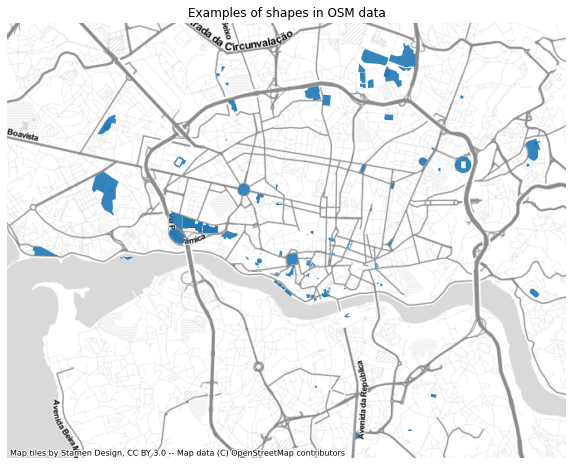

The concatenated poi geo df has 40489 entries.


In [84]:
# concatenating both dfs
poi_concat = poi_lisbon_clean.append(poi_porto_clean)

# mapping some samples
poi_concat_copy = poi_concat.copy().head(100)
# to have background map need to change proj
poi_concat_copy = poi_concat_copy.set_crs(epsg=4326).to_crs(epsg=3857)
ax = poi_concat_copy.plot(alpha=.9, figsize=(15,8))
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=13)
ax.set_axis_off()
plt.title('Examples of shapes in OSM data')
plt.show()
print(f'The concatenated poi geo df has {poi_concat.shape[0]} entries.')

## Checking the points and polygons that could prove relevant for attracting people to Green Spaces

In [20]:
poi_concat['amenity'].unique()
#need to go through the list and focus only on those that are interesting 
#restaurant, cafe, recycling, police, toilets, school, bus_station, kindergarten,  fountain, bench, drinking water, university
# sport club, concert_hall

array([None, 'school', 'parking', 'townhall', 'club', 'marketplace',
       'university', 'public_building', 'fountain', 'library',
       'restaurant', 'hospital', 'place_of_worship', 'police', 'college',
       'bus_station', 'taxi', 'veterinary', 'fuel', 'car_wash', 'cafe',
       'post_office', 'bar', 'theatre', 'kindergarten', 'parking_space',
       'pharmacy', 'cinema', 'bank', 'dentist', 'driving_school',
       'typography', 'toilets', 'clinic', 'nightclub', 'social_facility',
       'car_rental', 'taxi_rank', 'trade_union', 'press', 'factory',
       'sport_club', 'fast_food', 'associaton', 'courthouse', 'travel',
       'fire_station', 'prison', 'planetarium', 'recycling',
       'nursing_home', 'community_centre', 'vehicle_inspection',
       'printer', 'shelter', 'lavoir', 'crematorium', 'motorcycle_rental',
       'language_school', 'vending_machine', 'childcare', 'concert_hall',
       'public_bookcase', 'arts_centre', 'public_bath', 'waste_disposal',
       'payment_cen

In [21]:
poi_concat['natural'].unique()

array([None, 'water', 'scrub', 'beach', 'grassland', 'cliff', 'rock',
       'islet', 'spring', 'wood', 'bare_rock', 'heath', 'grass',
       'shingle', 'mud', 'wetland', 'tree_row', 'fell', 'yes'],
      dtype=object)

In [22]:
poi_concat['shop'].unique()

array([None, 'hardware', 'mall', 'electronics', 'department_store',
       'supermarket', 'wholesale', 'car', 'sports', 'art_gallery', 'yes',
       'clothes', 'jewelry', 'alcohol', 'lighting', 'books', 'drugstore',
       'butcher', 'watches', 'interior_decoration', 'lottery', 'music',
       'doityourself', 'perfumery', 'hairdresser', 'convenience',
       'bakery', 'swimming_pool', 'shoes', 'frame', 'kiosk',
       'medical_supply', 'optician', 'mobile_phone', 'toys',
       'greengrocer', 'travel_agency', 'furniture', 'hifi', 'leather',
       'fabric', 'houseware', 'baby_goods', 'bicycle', 'florist',
       'pawnbroker', 'gift', 'garden_centre', 'car_repair', 'art',
       'antiques', 'laundry', 'photo', 'Borrachas_e_Plasticos', 'optics',
       'electrical', 'chemist', 'furniture;charity', 'religion',
       'locksmith', 'fireplace', 'wine', 'rental', 'ticket',
       'variety_store', 'copyshop'], dtype=object)

In [23]:
poi_concat['leisure'].unique()

array(['sports_centre', 'garden', None, 'park', 'stadium', 'track',
       'dog_park', 'pitch', 'fitness_centre', 'sports_hall', 'playground',
       'swimming_pool', 'bandstand', 'recreation_ground', 'common',
       'miniature_golf', 'marina', 'yes', 'horse_riding', 'bleachers',
       'outdoor_seating', 'fitness_station'], dtype=object)

In [24]:
poi_concat['tourism'].unique()

array([None, 'attraction', 'museum', 'hotel', 'guest_house', 'hostel',
       'artwork', 'yes', 'apartment', 'viewpoint', 'picnic_site'],
      dtype=object)

# Transforming OSM features

In [89]:
# reducing geo_df columns, only leavin one valid column
def new_desc(geo):
    geo['desc'] = None
    lst_cols = ['amenity', 
                'natural', 
                'shop', 
                'leisure', 
                'tourism']
    for c, row in geo.iterrows():
        # listing all appearing POIs in one cell with a concat name
        trues = [f'{i}_{row[i]}' for i in lst_cols if row[i] != None]
        if len(trues) > 0:
            geo.at[c, 'desc'] = trues[0]
        else: 
            geo.at[c, 'desc'] = None
        print(f'done: {c}')
        
    
    geo = geo[['geometry', 'desc']]
    geo = geo.dropna(subset=['desc'])
    geo= geo.reset_index(drop=True)
    
    return geo

desc_geo = new_desc(poi_concat.copy())

done: 41657
done: 41676
done: 41677
done: 41678
done: 41680
done: 41683
done: 41685
done: 41688
done: 41689
done: 41690
done: 41691
done: 41700
done: 41706
done: 41708
done: 41711
done: 41712
done: 41714
done: 41717
done: 41723
done: 41731
done: 41732
done: 41734
done: 41738
done: 41740
done: 41741
done: 41744
done: 41748
done: 41750
done: 41751
done: 41756
done: 41758
done: 41759
done: 41760
done: 41761
done: 41766
done: 41780
done: 41788
done: 41789
done: 41791
done: 41811
done: 41814
done: 41819
done: 41820
done: 41825
done: 41846
done: 41847
done: 41848
done: 41851
done: 41852
done: 41853
done: 41855
done: 41856
done: 41857
done: 41858
done: 41860
done: 41861
done: 41862
done: 41863
done: 41866
done: 41867
done: 41868
done: 41871
done: 41872
done: 41873
done: 41874
done: 41876
done: 41881
done: 41885
done: 41895
done: 41898
done: 41902
done: 41903
done: 41904
done: 41905
done: 41907
done: 41912
done: 41913
done: 41914
done: 41924
done: 41934
done: 41935
done: 41936
done: 41937
done

done: 49021
done: 49022
done: 49028
done: 49029
done: 49031
done: 49034
done: 49035
done: 49038
done: 49058
done: 49059
done: 49060
done: 49063
done: 49064
done: 49065
done: 49066
done: 49067
done: 49106
done: 49131
done: 49134
done: 49197
done: 49220
done: 49221
done: 49222
done: 49223
done: 49224
done: 49225
done: 49226
done: 49261
done: 49264
done: 49269
done: 49270
done: 49271
done: 49282
done: 49288
done: 49297
done: 49298
done: 49307
done: 49308
done: 49310
done: 49315
done: 49327
done: 49331
done: 49334
done: 49335
done: 49336
done: 49337
done: 49338
done: 49351
done: 49356
done: 49359
done: 49378
done: 49380
done: 49382
done: 49385
done: 49387
done: 49388
done: 49389
done: 49392
done: 49393
done: 49397
done: 49398
done: 49399
done: 49400
done: 49414
done: 49415
done: 49416
done: 49417
done: 49418
done: 49419
done: 49420
done: 49421
done: 49422
done: 49423
done: 49424
done: 49426
done: 49428
done: 49434
done: 49438
done: 49447
done: 49452
done: 49453
done: 49455
done: 49458
done

done: 57098
done: 57105
done: 57106
done: 57109
done: 57113
done: 57127
done: 57143
done: 57145
done: 57179
done: 57225
done: 57226
done: 57244
done: 57247
done: 57251
done: 57252
done: 57253
done: 57254
done: 57255
done: 57256
done: 57257
done: 57258
done: 57283
done: 57288
done: 57290
done: 57291
done: 57306
done: 57308
done: 57336
done: 57339
done: 57346
done: 57349
done: 57354
done: 57355
done: 57357
done: 57359
done: 57377
done: 57382
done: 57383
done: 57384
done: 57394
done: 57398
done: 57401
done: 57402
done: 57407
done: 57419
done: 57423
done: 57424
done: 57425
done: 57429
done: 57430
done: 57431
done: 57432
done: 57433
done: 57434
done: 57435
done: 57438
done: 57439
done: 57444
done: 57446
done: 57447
done: 57448
done: 57449
done: 57450
done: 57453
done: 57454
done: 57455
done: 57456
done: 57457
done: 57458
done: 57459
done: 57460
done: 57461
done: 57462
done: 57463
done: 57464
done: 57466
done: 57469
done: 57470
done: 57471
done: 57479
done: 57490
done: 57492
done: 57493
done

done: 66744
done: 66745
done: 66746
done: 66747
done: 66748
done: 66812
done: 66816
done: 66817
done: 66818
done: 66827
done: 66828
done: 66830
done: 66833
done: 66834
done: 66838
done: 66840
done: 66846
done: 66847
done: 66848
done: 66849
done: 66850
done: 66851
done: 66853
done: 66856
done: 66858
done: 66859
done: 66862
done: 66875
done: 66876
done: 66877
done: 66878
done: 66881
done: 66885
done: 66887
done: 66888
done: 66889
done: 66890
done: 66914
done: 66915
done: 66917
done: 66918
done: 66973
done: 67078
done: 67080
done: 67082
done: 67149
done: 67240
done: 67241
done: 67242
done: 67247
done: 67248
done: 67251
done: 67311
done: 67355
done: 67379
done: 67504
done: 67547
done: 67548
done: 67549
done: 67556
done: 67557
done: 67558
done: 67564
done: 67565
done: 67571
done: 67572
done: 67586
done: 67587
done: 67588
done: 67589
done: 67592
done: 67600
done: 67606
done: 67607
done: 67611
done: 67667
done: 67670
done: 67677
done: 67715
done: 67744
done: 67754
done: 67755
done: 67767
done

done: 75188
done: 75189
done: 75190
done: 75191
done: 75192
done: 75195
done: 75196
done: 75204
done: 75209
done: 75210
done: 75211
done: 75212
done: 75229
done: 75230
done: 75233
done: 75234
done: 75235
done: 75236
done: 75237
done: 75238
done: 75239
done: 75240
done: 75241
done: 75242
done: 75243
done: 75244
done: 75245
done: 75246
done: 75247
done: 75248
done: 75249
done: 75250
done: 75251
done: 75252
done: 75253
done: 75254
done: 75255
done: 75256
done: 75257
done: 75258
done: 75259
done: 75260
done: 75261
done: 75262
done: 75263
done: 75264
done: 75265
done: 75268
done: 75269
done: 75270
done: 75271
done: 75275
done: 75278
done: 75279
done: 75280
done: 75281
done: 75282
done: 75283
done: 75284
done: 75285
done: 75286
done: 75287
done: 75288
done: 75289
done: 75290
done: 75291
done: 75292
done: 75293
done: 75294
done: 75295
done: 75296
done: 75297
done: 75298
done: 75299
done: 75300
done: 75312
done: 75314
done: 75315
done: 75316
done: 75317
done: 75319
done: 75320
done: 75321
done

done: 181341
done: 181395
done: 181400
done: 181408
done: 181429
done: 181449
done: 181536
done: 181539
done: 181542
done: 181583
done: 181591
done: 181614
done: 181617
done: 181643
done: 181653
done: 181654
done: 181655
done: 181658
done: 181663
done: 181714
done: 181757
done: 181762
done: 181782
done: 181786
done: 181794
done: 181830
done: 181890
done: 181893
done: 181926
done: 181927
done: 181987
done: 181999
done: 182004
done: 182116
done: 182235
done: 182240
done: 182353
done: 182364
done: 182381
done: 182457
done: 182459
done: 182462
done: 182517
done: 182521
done: 182545
done: 182625
done: 182637
done: 182675
done: 182676
done: 182677
done: 182685
done: 182694
done: 182699
done: 182710
done: 182730
done: 182787
done: 182851
done: 182857
done: 182858
done: 182859
done: 182860
done: 182915
done: 182961
done: 183005
done: 183021
done: 183028
done: 183030
done: 183079
done: 183083
done: 183120
done: 183148
done: 183249
done: 183302
done: 183336
done: 183361
done: 183363
done: 183365

done: 198146
done: 198147
done: 198148
done: 198153
done: 198154
done: 198155
done: 198156
done: 198158
done: 198160
done: 198167
done: 198171
done: 198173
done: 198175
done: 198183
done: 198197
done: 198205
done: 198206
done: 198211
done: 198224
done: 198226
done: 198227
done: 198230
done: 198236
done: 198237
done: 198238
done: 198239
done: 198240
done: 198241
done: 198242
done: 198243
done: 198244
done: 198250
done: 198251
done: 198252
done: 198256
done: 198263
done: 198267
done: 198268
done: 198269
done: 198270
done: 198274
done: 198278
done: 198279
done: 198281
done: 198282
done: 198283
done: 198289
done: 198306
done: 198336
done: 198338
done: 198339
done: 198345
done: 198346
done: 198347
done: 198348
done: 198350
done: 198351
done: 198352
done: 198353
done: 198354
done: 198355
done: 198357
done: 198363
done: 198369
done: 198379
done: 198380
done: 198381
done: 198382
done: 198383
done: 198384
done: 198385
done: 198386
done: 198388
done: 198403
done: 198410
done: 198412
done: 198413

done: 205805
done: 205806
done: 205807
done: 205808
done: 205810
done: 205811
done: 205812
done: 205813
done: 205824
done: 205825
done: 205838
done: 205850
done: 205851
done: 205856
done: 205862
done: 205864
done: 205865
done: 205868
done: 205873
done: 205879
done: 205881
done: 205883
done: 205894
done: 205895
done: 205918
done: 205920
done: 205924
done: 205928
done: 205929
done: 205936
done: 205937
done: 205938
done: 205939
done: 205940
done: 205941
done: 205944
done: 205980
done: 205981
done: 206021
done: 206031
done: 206066
done: 206067
done: 206068
done: 206069
done: 206070
done: 206071
done: 206073
done: 206079
done: 206080
done: 206091
done: 206098
done: 206099
done: 206100
done: 206106
done: 206107
done: 206109
done: 206122
done: 206123
done: 206124
done: 206135
done: 206139
done: 206160
done: 206162
done: 206165
done: 206166
done: 206167
done: 206172
done: 206175
done: 206176
done: 206178
done: 206179
done: 206183
done: 206197
done: 206201
done: 206202
done: 206204
done: 206205

done: 219304
done: 219305
done: 219315
done: 219359
done: 219361
done: 219365
done: 219366
done: 219403
done: 219404
done: 219407
done: 219408
done: 219409
done: 219473
done: 219474
done: 219475
done: 219476
done: 219477
done: 219480
done: 219481
done: 219482
done: 219483
done: 219484
done: 219485
done: 219486
done: 219487
done: 219496
done: 219497
done: 219500
done: 219501
done: 219502
done: 219528
done: 219532
done: 219547
done: 219597
done: 219700
done: 219701
done: 219702
done: 219706
done: 219709
done: 219711
done: 219712
done: 219713
done: 219719
done: 219722
done: 219736
done: 219744
done: 219745
done: 219770
done: 219785
done: 219789
done: 219790
done: 219791
done: 219792
done: 219796
done: 219798
done: 219802
done: 219803
done: 219824
done: 219899
done: 219900
done: 219901
done: 219902
done: 219905
done: 219906
done: 219938
done: 219968
done: 219973
done: 219991
done: 219993
done: 220048
done: 220049
done: 220050
done: 220082
done: 220149
done: 220166
done: 220354
done: 220526

done: 233342
done: 233343
done: 233344
done: 233353
done: 233409
done: 233446
done: 233447
done: 233451
done: 233455
done: 233457
done: 233475
done: 233476
done: 233478
done: 233482
done: 233484
done: 233485
done: 233486
done: 233487
done: 233490
done: 233495
done: 233497
done: 233498
done: 233500
done: 233501
done: 233502
done: 233503
done: 233504
done: 233505
done: 233506
done: 233507
done: 233508
done: 233509
done: 233510
done: 233511
done: 233512
done: 233513
done: 233514
done: 233515
done: 233516
done: 233517
done: 233518
done: 233519
done: 233523
done: 233524
done: 233531
done: 233532
done: 233534
done: 233535
done: 233536
done: 233543
done: 233544
done: 233549
done: 233550
done: 233553
done: 233554
done: 233565
done: 233566
done: 233567
done: 233569
done: 233573
done: 233584
done: 233585
done: 233591
done: 233592
done: 233612
done: 233613
done: 233614
done: 233619
done: 233620
done: 233621
done: 233622
done: 233623
done: 233625
done: 233626
done: 233627
done: 233629
done: 233630

done: 248254
done: 248255
done: 248256
done: 248257
done: 248258
done: 248260
done: 248262
done: 248263
done: 248264
done: 248292
done: 248293
done: 248294
done: 248295
done: 248297
done: 248301
done: 248302
done: 248303
done: 248304
done: 248305
done: 248306
done: 248307
done: 248308
done: 248309
done: 248318
done: 248319
done: 248320
done: 248321
done: 248322
done: 248324
done: 248326
done: 248328
done: 248342
done: 248343
done: 248347
done: 248348
done: 248349
done: 248350
done: 248351
done: 248352
done: 248353
done: 248354
done: 248355
done: 248356
done: 248357
done: 248378
done: 248391
done: 248392
done: 248393
done: 248394
done: 248395
done: 248403
done: 248404
done: 248409
done: 248421
done: 248422
done: 248424
done: 248430
done: 248431
done: 248432
done: 248440
done: 248462
done: 248465
done: 248477
done: 248482
done: 248491
done: 248493
done: 248499
done: 248507
done: 248508
done: 248509
done: 248510
done: 248512
done: 248513
done: 248514
done: 248515
done: 248516
done: 248517

done: 302565
done: 302566
done: 302567
done: 302568
done: 302569
done: 302570
done: 302571
done: 302572
done: 302573
done: 302574
done: 302575
done: 302576
done: 302577
done: 302578
done: 302579
done: 302580
done: 302581
done: 302582
done: 302583
done: 302584
done: 302585
done: 302586
done: 302587
done: 302588
done: 302589
done: 302590
done: 302591
done: 302592
done: 302593
done: 302594
done: 302595
done: 302596
done: 302597
done: 302598
done: 302599
done: 302600
done: 302601
done: 302602
done: 302603
done: 302604
done: 302605
done: 302606
done: 302607
done: 302608
done: 302609
done: 302610
done: 302611
done: 302612
done: 302613
done: 302614
done: 302615
done: 302616
done: 302617
done: 302618
done: 302619
done: 302620
done: 302621
done: 302622
done: 302623
done: 302624
done: 302625
done: 302626
done: 302627
done: 302628
done: 302629
done: 302630
done: 302631
done: 302632
done: 302633
done: 302634
done: 302635
done: 302636
done: 302637
done: 302638
done: 302639
done: 302640
done: 302641

done: 413771
done: 413772
done: 413773
done: 413774
done: 413775
done: 413776
done: 413777
done: 413778
done: 413779
done: 413780
done: 413781
done: 413782
done: 413783
done: 413784
done: 413785
done: 413786
done: 413787
done: 413788
done: 413789
done: 413790
done: 413791
done: 413792
done: 413793
done: 413794
done: 413795
done: 413796
done: 413797
done: 413798
done: 413799
done: 413800
done: 413801
done: 413802
done: 413803
done: 413804
done: 413805
done: 413806
done: 413807
done: 413808
done: 413809
done: 413810
done: 413811
done: 413812
done: 413813
done: 413814
done: 413815
done: 413816
done: 413817
done: 413818
done: 413819
done: 413820
done: 413821
done: 413822
done: 413823
done: 413824
done: 413825
done: 413826
done: 413827
done: 413828
done: 413829
done: 413830
done: 413831
done: 413832
done: 413833
done: 413834
done: 413835
done: 413836
done: 413837
done: 413838
done: 413839
done: 413840
done: 413841
done: 413842
done: 413843
done: 413844
done: 413845
done: 413846
done: 413847

done: 415332
done: 415333
done: 415334
done: 415335
done: 415336
done: 415337
done: 415338
done: 415339
done: 415340
done: 415341
done: 415342
done: 415343
done: 415344
done: 415345
done: 415346
done: 415347
done: 415348
done: 415349
done: 415350
done: 415351
done: 415352
done: 415353
done: 415354
done: 415355
done: 415356
done: 415357
done: 415358
done: 415359
done: 415360
done: 415361
done: 415362
done: 415363
done: 415364
done: 415365
done: 415366
done: 415367
done: 415368
done: 415369
done: 415370
done: 415371
done: 415372
done: 415373
done: 415374
done: 415375
done: 415376
done: 415377
done: 415378
done: 415379
done: 415380
done: 415381
done: 415382
done: 415383
done: 415384
done: 415385
done: 415386
done: 415387
done: 415388
done: 415389
done: 415390
done: 415391
done: 415392
done: 415393
done: 415394
done: 415395
done: 415396
done: 415397
done: 415398
done: 415399
done: 415400
done: 415401
done: 415402
done: 415403
done: 415404
done: 415405
done: 415406
done: 415407
done: 415408

done: 438490
done: 438491
done: 438492
done: 438493
done: 438494
done: 438495
done: 438496
done: 438497
done: 438498
done: 438499
done: 438500
done: 438501
done: 438502
done: 438503
done: 438504
done: 438505
done: 438506
done: 438507
done: 438508
done: 438509
done: 438510
done: 438511
done: 438512
done: 438513
done: 438514
done: 438515
done: 438516
done: 438517
done: 438518
done: 438519
done: 438520
done: 438521
done: 438522
done: 438523
done: 438524
done: 438525
done: 438526
done: 438527
done: 438528
done: 438529
done: 438530
done: 438531
done: 438532
done: 438533
done: 438534
done: 438535
done: 438536
done: 438537
done: 438538
done: 438539
done: 438540
done: 438541
done: 438542
done: 438543
done: 438544
done: 438545
done: 438546
done: 438547
done: 438548
done: 438549
done: 438550
done: 438551
done: 438552
done: 438553
done: 438554
done: 438555
done: 438556
done: 438557
done: 438558
done: 438559
done: 438560
done: 438561
done: 438562
done: 438563
done: 438564
done: 438565
done: 438566

done: 439939
done: 439940
done: 439941
done: 439942
done: 439943
done: 439944
done: 439945
done: 439946
done: 439947
done: 439948
done: 439949
done: 439950
done: 439951
done: 439952
done: 439953
done: 439954
done: 439955
done: 439956
done: 439957
done: 439958
done: 439959
done: 439960
done: 439961
done: 439962
done: 439963
done: 439964
done: 439965
done: 439966
done: 439967
done: 439968
done: 439969
done: 439970
done: 439971
done: 439972
done: 439973
done: 439974
done: 439975
done: 439976
done: 439977
done: 439978
done: 439979
done: 439980
done: 439981
done: 439982
done: 439983
done: 439984
done: 439985
done: 439986
done: 439987
done: 439988
done: 439989
done: 439990
done: 439991
done: 439992
done: 439993
done: 439994
done: 439995
done: 439996
done: 439997
done: 439998
done: 439999
done: 440000
done: 440001
done: 440002
done: 440003
done: 440004
done: 440005
done: 440006
done: 440007
done: 440008
done: 440009
done: 440010
done: 440011
done: 440012
done: 440013
done: 440014
done: 440015

done: 441221
done: 441222
done: 441223
done: 441224
done: 441225
done: 441226
done: 441227
done: 441228
done: 441229
done: 441230
done: 441231
done: 441232
done: 441233
done: 441234
done: 441235
done: 441236
done: 441237
done: 441238
done: 441239
done: 441240
done: 441241
done: 441242
done: 441243
done: 441244
done: 441245
done: 441246
done: 441247
done: 441248
done: 441249
done: 441250
done: 441251
done: 441252
done: 441253
done: 441254
done: 441255
done: 441256
done: 441257
done: 441258
done: 441259
done: 441260
done: 441261
done: 441262
done: 441263
done: 441264
done: 441265
done: 441266
done: 441267
done: 441268
done: 441269
done: 441270
done: 441271
done: 441272
done: 441273
done: 441274
done: 441275
done: 441276
done: 441277
done: 441278
done: 441279
done: 441280
done: 441281
done: 441282
done: 441283
done: 441284
done: 441285
done: 441286
done: 441287
done: 441288
done: 441289
done: 441290
done: 441291
done: 441292
done: 441293
done: 441294
done: 441295
done: 441296
done: 441297

done: 442491
done: 442492
done: 442493
done: 442494
done: 442495
done: 442496
done: 442497
done: 442498
done: 442499
done: 442500
done: 442501
done: 442502
done: 442503
done: 442504
done: 442505
done: 442506
done: 442507
done: 442508
done: 442509
done: 442510
done: 442511
done: 442512
done: 442513
done: 442514
done: 442515
done: 442516
done: 442517
done: 442518
done: 442519
done: 442520
done: 442521
done: 442522
done: 442523
done: 442524
done: 442525
done: 442526
done: 442527
done: 442528
done: 442529
done: 442530
done: 442531
done: 442532
done: 442533
done: 442534
done: 442535
done: 442536
done: 442537
done: 442538
done: 442539
done: 442540
done: 442541
done: 442542
done: 442543
done: 442544
done: 442545
done: 442546
done: 442547
done: 442548
done: 442549
done: 442550
done: 442551
done: 442552
done: 442553
done: 442554
done: 442555
done: 442556
done: 442557
done: 442558
done: 442559
done: 442560
done: 442561
done: 442562
done: 442563
done: 442564
done: 442565
done: 442566
done: 442567

done: 443992
done: 443993
done: 443994
done: 443995
done: 443996
done: 443997
done: 443998
done: 443999
done: 444000
done: 444001
done: 444002
done: 444003
done: 444004
done: 444005
done: 444006
done: 444007
done: 444008
done: 444009
done: 444010
done: 444011
done: 444012
done: 444013
done: 444014
done: 444015
done: 444016
done: 444017
done: 444018
done: 444019
done: 444020
done: 444021
done: 444022
done: 444023
done: 444024
done: 444025
done: 444026
done: 444027
done: 444028
done: 444029
done: 444030
done: 444031
done: 444032
done: 444033
done: 444034
done: 444035
done: 444036
done: 444037
done: 444038
done: 444039
done: 444040
done: 444041
done: 444042
done: 444043
done: 444044
done: 444045
done: 444046
done: 444047
done: 444048
done: 444049
done: 444050
done: 444051
done: 444052
done: 444053
done: 444054
done: 444055
done: 444056
done: 444057
done: 444058
done: 444059
done: 444060
done: 444061
done: 444062
done: 444063
done: 444064
done: 444065
done: 444066
done: 444067
done: 444068

done: 445491
done: 445492
done: 445493
done: 445494
done: 445495
done: 445496
done: 445497
done: 445498
done: 445499
done: 445500
done: 445501
done: 445502
done: 445503
done: 445504
done: 445505
done: 445506
done: 445507
done: 445508
done: 445509
done: 445510
done: 445511
done: 445512
done: 445513
done: 445514
done: 445515
done: 445516
done: 445517
done: 445518
done: 445519
done: 445520
done: 445521
done: 445522
done: 445523
done: 445524
done: 445525
done: 445526
done: 445527
done: 445528
done: 445529
done: 445530
done: 445531
done: 445532
done: 445533
done: 445534
done: 445535
done: 445536
done: 445537
done: 445538
done: 445539
done: 445540
done: 445541
done: 445542
done: 445543
done: 445544
done: 445545
done: 445546
done: 445547
done: 445548
done: 445549
done: 445550
done: 445551
done: 445552
done: 445553
done: 445554
done: 445555
done: 445556
done: 445557
done: 445558
done: 445559
done: 445560
done: 445561
done: 445562
done: 445563
done: 445564
done: 445565
done: 445566
done: 445567

done: 446991
done: 446992
done: 446993
done: 446994
done: 446995
done: 446996
done: 446997
done: 446998
done: 446999
done: 447000
done: 447001
done: 447002
done: 447003
done: 447004
done: 447005
done: 447006
done: 447007
done: 447008
done: 447009
done: 447010
done: 447011
done: 447012
done: 447013
done: 447014
done: 447015
done: 447016
done: 447017
done: 447018
done: 447019
done: 447020
done: 447021
done: 447022
done: 447023
done: 447024
done: 447025
done: 447026
done: 447027
done: 447028
done: 447029
done: 447030
done: 447031
done: 447032
done: 447033
done: 447034
done: 447035
done: 447036
done: 447037
done: 447038
done: 447039
done: 447040
done: 447041
done: 447042
done: 447043
done: 447044
done: 447045
done: 447046
done: 447047
done: 447048
done: 447049
done: 447050
done: 447051
done: 447052
done: 447053
done: 447054
done: 447055
done: 447056
done: 447057
done: 447058
done: 447059
done: 447060
done: 447061
done: 447062
done: 447063
done: 447064
done: 447065
done: 447066
done: 447067

done: 448490
done: 448491
done: 448492
done: 448493
done: 448494
done: 448495
done: 448496
done: 448497
done: 448498
done: 448499
done: 448500
done: 448501
done: 448502
done: 448503
done: 448504
done: 448505
done: 448506
done: 448507
done: 448508
done: 448509
done: 448510
done: 448511
done: 448512
done: 448513
done: 448514
done: 448515
done: 448516
done: 448517
done: 448518
done: 448519
done: 448520
done: 448521
done: 448522
done: 448523
done: 448524
done: 448525
done: 448526
done: 448527
done: 448528
done: 448529
done: 448530
done: 448531
done: 448532
done: 448533
done: 448534
done: 448535
done: 448536
done: 448537
done: 448538
done: 448539
done: 448540
done: 448541
done: 448542
done: 448543
done: 448544
done: 448545
done: 448546
done: 448547
done: 448548
done: 448549
done: 448550
done: 448551
done: 448552
done: 448553
done: 448554
done: 448555
done: 448556
done: 448557
done: 448558
done: 448559
done: 448560
done: 448561
done: 448562
done: 448563
done: 448564
done: 448565
done: 448566

done: 449990
done: 449991
done: 449992
done: 449993
done: 449994
done: 449995
done: 449996
done: 449997
done: 449998
done: 449999
done: 450000
done: 450001
done: 450002
done: 450003
done: 450004
done: 450005
done: 450006
done: 450007
done: 450008
done: 450009
done: 450010
done: 450011
done: 450012
done: 450013
done: 450014
done: 450015
done: 450016
done: 450017
done: 450018
done: 450019
done: 450020
done: 450021
done: 450022
done: 450023
done: 450024
done: 450025
done: 450026
done: 450027
done: 450028
done: 450029
done: 450030
done: 450031
done: 450032
done: 450033
done: 450034
done: 450035
done: 450036
done: 450037
done: 450038
done: 450039
done: 450040
done: 450041
done: 450042
done: 450043
done: 450044
done: 450045
done: 450046
done: 450047
done: 450048
done: 450049
done: 450050
done: 450051
done: 450052
done: 450053
done: 450054
done: 450055
done: 450056
done: 450057
done: 450058
done: 450059
done: 450060
done: 450061
done: 450062
done: 450063
done: 450064
done: 450065
done: 450066

done: 451507
done: 451508
done: 451509
done: 451510
done: 451511
done: 451512
done: 451513
done: 451514
done: 451515
done: 451516
done: 451517
done: 451518
done: 451519
done: 451520
done: 451521
done: 451522
done: 451523
done: 451524
done: 451525
done: 451526
done: 451527
done: 451528
done: 451529
done: 451530
done: 451531
done: 451532
done: 451533
done: 451534
done: 451535
done: 451536
done: 451537
done: 451538
done: 451539
done: 451540
done: 451541
done: 451542
done: 451543
done: 451544
done: 451545
done: 451546
done: 451547
done: 451548
done: 451549
done: 451550
done: 451551
done: 451552
done: 451553
done: 451554
done: 451555
done: 451556
done: 451557
done: 451558
done: 451559
done: 451560
done: 451561
done: 451562
done: 451563
done: 451564
done: 451565
done: 451566
done: 451567
done: 451568
done: 451569
done: 451570
done: 451571
done: 451572
done: 451573
done: 451574
done: 451575
done: 451576
done: 451577
done: 451578
done: 451579
done: 451580
done: 451581
done: 451582
done: 451583

done: 452785
done: 452786
done: 452787
done: 452788
done: 452789
done: 452790
done: 452791
done: 452792
done: 452793
done: 452794
done: 452795
done: 452796
done: 452797
done: 452798
done: 452799
done: 452800
done: 452801
done: 452802
done: 452803
done: 452804
done: 452805
done: 452806
done: 452807
done: 452808
done: 452809
done: 452810
done: 452811
done: 452812
done: 452813
done: 452814
done: 452815
done: 452816
done: 452817
done: 452818
done: 452819
done: 452820
done: 452821
done: 452822
done: 452823
done: 452824
done: 452825
done: 452826
done: 452827
done: 452828
done: 452829
done: 452830
done: 452831
done: 452832
done: 452833
done: 452834
done: 452835
done: 452836
done: 452837
done: 452838
done: 452839
done: 452840
done: 452841
done: 452842
done: 452843
done: 452844
done: 452845
done: 452846
done: 452847
done: 452848
done: 452849
done: 452850
done: 452851
done: 452852
done: 452853
done: 452854
done: 452855
done: 452856
done: 452857
done: 452858
done: 452859
done: 452860
done: 452861

done: 456324
done: 456422
done: 456669
done: 456677
done: 456678
done: 457137
done: 457138
done: 457197
done: 457200
done: 457201
done: 458581
done: 458582
done: 458583
done: 458584
done: 458585
done: 458586
done: 458587
done: 458975
done: 458995
done: 459196
done: 459369
done: 459644
done: 459645
done: 459646
done: 459647
done: 459648
done: 459649
done: 459650
done: 459651
done: 459652
done: 459653
done: 459654
done: 459655
done: 459656
done: 459657
done: 459658
done: 459659
done: 459660
done: 459661
done: 459662
done: 459663
done: 459664
done: 459665
done: 459666
done: 459667
done: 459668
done: 459669
done: 459670
done: 459671
done: 459672
done: 459673
done: 459674
done: 459675
done: 459676
done: 459677
done: 459678
done: 459679
done: 459680
done: 459681
done: 459682
done: 459683
done: 459684
done: 459685
done: 459686
done: 459687
done: 459688
done: 459689
done: 459690
done: 459691
done: 459692
done: 459693
done: 459697
done: 459698
done: 459699
done: 459700
done: 459701
done: 459702

done: 467129
done: 467131
done: 467133
done: 467234
done: 467236
done: 467237
done: 467238
done: 467239
done: 467240
done: 467241
done: 467242
done: 467245
done: 467246
done: 467247
done: 467248
done: 467249
done: 467250
done: 467429
done: 467490
done: 467491
done: 467492
done: 467497
done: 467697
done: 467797
done: 467801
done: 467802
done: 467804
done: 467816
done: 467817
done: 467818
done: 467819
done: 467820
done: 467858
done: 467859
done: 467860
done: 467861
done: 467862
done: 467864
done: 467865
done: 467866
done: 467867
done: 467873
done: 467877
done: 467880
done: 467883
done: 467890
done: 467896
done: 467897
done: 467916
done: 467919
done: 467930
done: 467936
done: 467938
done: 467939
done: 467940
done: 467941
done: 467942
done: 467943
done: 467944
done: 467947
done: 467969
done: 467976
done: 468003
done: 468009
done: 468010
done: 468051
done: 468052
done: 468066
done: 468067
done: 468068
done: 468079
done: 468080
done: 468081
done: 468083
done: 468084
done: 468085
done: 468097

done: 476357
done: 476358
done: 476359
done: 476360
done: 476361
done: 476362
done: 476363
done: 476364
done: 476365
done: 476366
done: 476367
done: 476368
done: 476369
done: 476370
done: 476371
done: 476372
done: 476373
done: 476374
done: 476375
done: 476376
done: 476377
done: 476378
done: 476379
done: 476380
done: 476381
done: 476382
done: 476383
done: 476384
done: 476385
done: 476386
done: 476387
done: 476388
done: 476389
done: 476390
done: 476391
done: 476392
done: 476393
done: 476394
done: 476395
done: 476396
done: 476397
done: 476398
done: 476399
done: 476400
done: 476401
done: 476402
done: 476403
done: 476404
done: 476405
done: 476406
done: 476407
done: 476408
done: 476409
done: 476410
done: 476411
done: 476412
done: 476413
done: 476414
done: 476415
done: 476416
done: 476417
done: 476418
done: 476419
done: 476420
done: 476421
done: 476422
done: 476423
done: 476424
done: 476425
done: 476426
done: 476427
done: 476428
done: 476429
done: 476430
done: 476431
done: 476432
done: 476433

done: 484214
done: 484216
done: 484217
done: 484218
done: 484220
done: 484221
done: 484222
done: 484223
done: 484224
done: 484229
done: 484230
done: 484231
done: 484234
done: 484235
done: 484288
done: 484289
done: 484295
done: 484296
done: 484298
done: 484304
done: 484313
done: 484314
done: 484325
done: 484334
done: 484348
done: 484349
done: 484350
done: 484351
done: 484356
done: 484357
done: 484359
done: 484360
done: 484361
done: 484370
done: 484417
done: 484418
done: 484419
done: 484421
done: 484422
done: 484423
done: 484424
done: 484426
done: 484427
done: 484428
done: 484429
done: 484430
done: 484436
done: 484437
done: 484438
done: 484440
done: 484441
done: 484459
done: 484460
done: 484463
done: 484464
done: 484466
done: 484467
done: 484469
done: 484470
done: 484472
done: 484473
done: 484475
done: 484479
done: 484480
done: 484481
done: 484482
done: 484483
done: 484495
done: 484496
done: 484499
done: 484515
done: 484525
done: 484526
done: 484530
done: 484532
done: 484538
done: 484552

In [91]:
desc_geo.sample(5)
# sowing all POIs in one column with a denied name

,geometry,desc
21331,"POLYGON ((-9.29204 38.83670, -9.29204 38.83672...",natural_water
25938,"POLYGON ((-9.38057 38.75566, -9.38057 38.75566...",amenity_parking
35234,"POLYGON ((-9.42615 38.86879, -9.42623 38.86875...",leisure_swimming_pool
8820,"POLYGON ((-9.38445 38.80041, -9.38444 38.80036...",amenity_parking
33788,"POLYGON ((-9.40092 38.81679, -9.40092 38.81680...",leisure_swimming_pool


In [133]:
# encoding all unique values
encoder = OneHotEncoder()
enc_df = encoder.fit_transform(desc_geo[['desc']])
enc_gdf_points = gpd.GeoDataFrame(enc_df.toarray(), columns=encoder.categories_)
enc_gdf_points = enc_gdf_points.join(desc_geo['geometry'])
columns = enc_gdf_points.columns

In [134]:
rename = {i:f'feat_{i[0]}' for i in columns if type(i)==tuple}
enc_gdf_points = enc_gdf_points.rename(columns=rename)
enc_gdf_points.shape # 284 columns!

(40489, 284)

In [177]:
# regrouping by green_areas index => caught all the points
grouped_gpd = joint_gpd.groupby('index').agg(agg)
grouped_gpd = grouped_gpd.rename(columns={'geometry':'points_feats', 'desc':'desc_points'})
grouped_gpd = grouped_gpd.merge(green_areas_shape[['index', 'geometry']], # get back green spaces geometries
                                left_index=True, 
                                right_on='index')
grouped_gpd.shape

(60, 300)

In [ ]:
grouped_gpd

,feat_amenity_animal_boarding,feat_amenity_animal_breeding,feat_amenity_animal_shelter,feat_amenity_arena,feat_amenity_arts_centre,feat_amenity_associaton,feat_amenity_atm,feat_amenity_auditorium,feat_amenity_bandstand,feat_amenity_bank,feat_amenity_bar,feat_amenity_bench,feat_amenity_bicycle_parking,feat_amenity_biergarten,feat_amenity_bureau_de_change,feat_amenity_bus_station,feat_amenity_cafe,feat_amenity_canteen,feat_amenity_car_rental,feat_amenity_car_wash,feat_amenity_casino,feat_amenity_childcare,feat_amenity_cinema,feat_amenity_clinic,feat_amenity_club,feat_amenity_college,feat_amenity_community_centre,feat_amenity_compressed_air,feat_amenity_concert_hall,feat_amenity_court_yard,feat_amenity_courthouse,feat_amenity_crematorium,feat_amenity_dentist,feat_amenity_disused:fuel,feat_amenity_doctors,feat_amenity_dojo,feat_amenity_drinking_water,feat_amenity_driving_school,feat_amenity_embassy,feat_amenity_events_venue,feat_amenity_exhibition_center,feat_amenity_factory,feat_amenity_fast_food,feat_amenity_ferry_terminal,feat_amenity_fire_station,feat_amenity_food_court,feat_amenity_fountain,feat_amenity_fuel,feat_amenity_funeral_hall,feat_amenity_hospital,feat_amenity_kindergarten,feat_amenity_language_school,feat_amenity_lavoir,feat_amenity_letter_box,feat_amenity_library,feat_amenity_locker_room,feat_amenity_love_hotel,feat_amenity_marketplace,feat_amenity_monastery,feat_amenity_motorcycle_parking,feat_amenity_motorcycle_rental,feat_amenity_music,feat_amenity_music_school,feat_amenity_nightclub,feat_amenity_nursing_home,feat_amenity_parking,feat_amenity_parking_space,feat_amenity_payment_centre,feat_amenity_pharmacy,feat_amenity_place_of_worship,feat_amenity_planetarium,feat_amenity_police,feat_amenity_post_office,feat_amenity_prep_school,feat_amenity_press,feat_amenity_printer,feat_amenity_prison,feat_amenity_pub,feat_amenity_public_bath,feat_amenity_public_bookcase,feat_amenity_public_building,feat_amenity_reception_desk,feat_amenity_recycling,feat_amenity_res,feat_amenity_research_institute,feat_amenity_restaurant,feat_amenity_school,feat_amenity_shelter,feat_amenity_shower,feat_amenity_social_centre,feat_amenity_social_facility,feat_amenity_spa,feat_amenity_sport_club,feat_amenity_students_home,feat_amenity_studio,feat_amenity_taxi,feat_amenity_taxi_rank,feat_amenity_theatre,feat_amenity_ticket_validator,feat_amenity_toilets,feat_amenity_townhall,feat_amenity_trade_union,feat_amenity_travel,feat_amenity_typography,feat_amenity_university,feat_amenity_vehicle_inspection,feat_amenity_vending_machine,feat_amenity_veterinary,feat_amenity_waste_disposal,feat_leisure_bandstand,feat_leisure_bleachers,feat_leisure_bowling_alley,feat_leisure_club,feat_leisure_common,feat_leisure_dance,feat_leisure_dog_park,feat_leisure_fitness_centre,feat_leisure_fitness_station,feat_leisure_garden,feat_leisure_golf_course,feat_leisure_grass,feat_leisure_horse_riding,feat_leisure_ice_rink,feat_leisure_marina,feat_leisure_miniature_golf,feat_leisure_nature_reserve,feat_leisure_outdoor_seating,feat_leisure_park,feat_leisure_pitch,feat_leisure_playground,feat_leisure_proposed,feat_leisure_recreation_ground,feat_leisure_social_club,feat_leisure_sports_centre,feat_leisure_sports_hall,feat_leisure_stadium,feat_leisure_swimming_pool,feat_leisure_track,feat_leisure_water_park,feat_leisure_yes,feat_natural_bare_rock,feat_natural_bay,feat_natural_beach,feat_natural_cliff,feat_natural_coastline,feat_natural_dune,feat_natural_dunes,feat_natural_farmland,feat_natural_fell,feat_natural_grass,feat_natural_grassland,feat_natural_heath,feat_natural_islet,feat_natural_land,feat_natural_mud,feat_natural_plateau,feat_natural_rock,feat_natural_sand,feat_natural_scree,feat_natural_scrub,feat_natural_shingle,feat_natural_shoal,feat_natural_spring,feat_natural_stone,feat_natural_strait,feat_natural_tree_row,feat_natural_valley,feat_natural_water,feat_natural_wetland,feat_natural_wood,feat_natural_yes,feat_shop_Borrachas_e_Plasticos,feat_shop_Venda_de_artigos_de_casa,fe

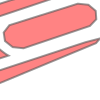

In [176]:
grouped_gpd.points_feats.loc[2][0]

In [161]:
m = folium.Map()

folium.Choropleth(grouped_gpd.loc[2].points_feats).add_to(m)

m


AttributeError: 'list' object has no attribute 'dropna'